## Create daily netcdf files for the period 1991 - 2015
There are two types of files. The new ones have a bunch of data variables and the old ones just have time, lat, lon, amplitude, and strokes. 

## Create “subset” files for:

a) Radars -  6 degree by 6 degree box centered on the radar
- Cedar City, Utah - 37 degrees 35 minutes 27 seconds; 112 51 44
- Phoenix, AZ - 33 17 21 ; 111 40 12
- Greer, SC - 34 53 00 ; 082 13 12
- Sterling, VA - 38 58 31 ; 077 28 40 
- Dener, CO - 39 47 12 ; 104 32 45

b) Columbia Plateau and Surroundings: 41 - 49 lat by 123 - 115 lon

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr

If all the files are in order and have the same variables, then this will work:

    conda install dask
    xr.open_mfdataset('/home/jsignell/erddapData/Cloud_to_Ground_Lightning/2014_01_*.nc', concat_dim='record')

If they don't have the same variables, then we can use the preprocess keyword to get just the variables that we know are in all the datasets:

    xr.open_mfdataset('/home/jsignell/erddapData/Cloud_to_Ground_Lightning/*_04_*.nc', 
                      concat_dim='record', preprocess=(lambda x: x[['strokes', 'amplitude']])


Benchmarking outcomes:
 - January 2014: 199ms
 - April 2014: 229ms
 - For all of 2014: 2.76s
 - For all Aprils: 20s

In [2]:
def func(ds):
    r = 3
    lat = 37+(35/60.)+(27/3600.)
    lon = -(112+(51/60.)+(44/3600.))
    bounding_box = ((ds.lat<(lat+r)) & (ds.lat>(lat-r)) & (ds.lon<(lon+r)) & (ds.lon>(lon-r)))
    return(ds[['strokes', 'amplitude']].where(bounding_box).dropna('record'))

In [ ]:
%%timeit
ds_all = xr.open_mfdataset('/home/jsignell/erddapData/Cloud_to_Ground_Lightning/*_04_*.nc', concat_dim='record', preprocess=func)

In [65]:
ds = func(xr.open_dataset('/home/jsignell/erddapData/Cloud_to_Ground_Lightning/2011_04_03.nc'))

In [4]:
ds

<xarray.Dataset>
Dimensions:    (record: 122913)
Coordinates:
    lon        (record) float64 -113.0 -113.0 -113.0 -112.8 -112.8 -113.8 ...
  * record     (record) int64 231 232 236 239 242 243 245 246 247 248 249 ...
    time       (record) datetime64[ns] 1991-04-01T19:33:15 ...
    lat        (record) float64 37.09 37.13 37.23 37.06 37.07 37.85 36.97 ...
Data variables:
    strokes    (record) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 3.0 1.0 ...
    amplitude  (record) float64 -26.8 -26.1 -33.5 -20.8 -22.0 -34.6 -25.1 ...
Attributes:
    featureType: point
    references: https://ghrc.nsstc.nasa.gov/uso/ds_docs/vaiconus/vaiconus_dataset.html
    author: jsignell@princeton.edu
    title: Cloud to Ground Lightning
    keywords: lightning
    history: Created by Princeton University Hydrometeorology Group at 2016-05-10 21:46:26.804269 
    institution: Data from NLDN, hosted by Princeton University
    Conventions: CF-1.6

## Python programs

 - Mean monthly CG flash density for a region; ~ 1km grid.
 - Mean monthly diurnal cycle of CG flash density by month for a region
 - Largest 100 CG flash density days (12 UTC - 12 UTC) for a region
 - JJA time (UTC) of maximum CG flash density (15 minute time resolution); ~ 1 km grid
 - “Amplitude” of the diurnal cycle; 15 minute time resolution ~1km grid.  CG flash density at the time of maximum flash density - CG flash density a time of minimum flash density divided by the mean flash density. 
 - Storm event CG flash density fields at ~.25 km grid resolution and 5 minute time resolution.  2D Gaussian distribution of each CG flash.  
 - Storm tracking for CG flash density fields. 

In [5]:
%matplotlib inline

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import seaborn as sbn

In [6]:
states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_lines',
                                      scale='50m',
                                      facecolor='none')
cmap = plt.cm.get_cmap('jet')
cmap.set_under(color='None')

In [7]:
def background(ax):
    ax.add_feature(states)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)
    return(ax)

This is where all the strikes hit for this month

In [8]:
x = ds.lon.values
y = ds.lat.values

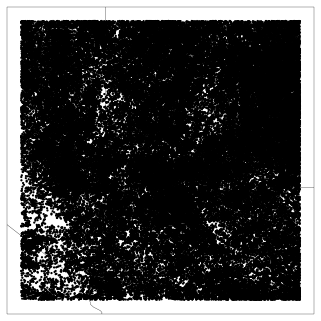

In [200]:
ax = background(plt.axes(projection=ccrs.PlateCarree()))
ax.scatter(x, y, c='black', edgecolor='None', s=5);

Here is an [example](http://stackoverflow.com/questions/11015252/countig-points-in-boxes-of-a-grid) of how we will go about gridding the data:

In [47]:
r = 3
lat = 37+(35/60.)+(27/3600.)
lon = -(112+(51/60.)+(44/3600.))

gridx = np.linspace(lon-.5, lon+.5, 100)
gridy = np.linspace(lat-.5, lat+.5, 100)

grid, _, _ = np.histogram2d(x, y, bins=[gridx, gridy])
density = grid.T

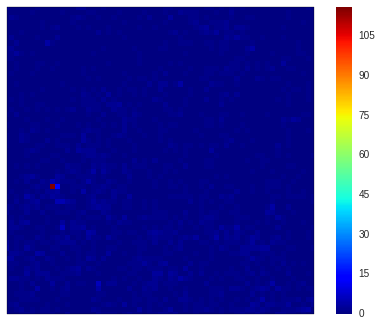

In [37]:
ax = background(plt.axes(projection=ccrs.PlateCarree()))
ax.set_extent([lon-.3, lon+.3, lat-.3, lat+.3])
den = ax.pcolor(gridx, gridy, density, cmap='jet')
plt.colorbar(den);

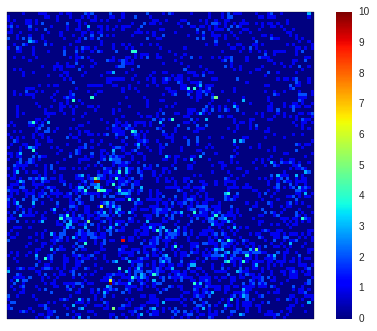

In [50]:
ax = background(plt.axes(projection=ccrs.PlateCarree()))
den = ax.pcolor(gridx, gridy, density, cmap='jet', vmax=10)
plt.colorbar(den);

In [52]:
grid.sum(axis=1)

array([  38.,   27.,   32.,   44.,   36.,   36.,   22.,   38.,   45.,
         39.,   25.,   38.,   44.,   32.,   37.,   27.,   28.,   32.,
         38.,   43.,   39.,   46.,   46.,   65.,   50.,   49.,   45.,
         46.,  109.,  103.,   48.,   47.,   42.,   62.,   59.,   53.,
         62.,   60.,   50.,   52.,   50.,   44.,   51.,   52.,   34.,
         41.,   35.,   47.,   54.,   43.,   53.,   45.,   34.,   40.,
         48.,   29.,   35.,   34.,   46.,   49.,   45.,   52.,   46.,
         48.,   50.,   41.,   47.,   48.,   30.,   39.,   51.,   53.,
         48.,   50.,   39.,   33.,   41.,   36.,   30.,   22.,   34.,
         32.,   31.,   27.,   36.,   38.,   37.,   36.,   20.,   32.,
         26.,   38.,   37.,   51.,   37.,   40.,   40.,   40.,   21.])

In [53]:
grid.sum(axis=0)

array([  27.,   46.,   44.,   47.,   44.,   40.,   45.,   38.,   43.,
         48.,   55.,   69.,   57.,   67.,   60.,   58.,   61.,   43.,
         63.,   58.,   67.,   60.,   59.,   43.,   49.,   62.,   55.,
         65.,   54.,   45.,   42.,   60.,   63.,   70.,   69.,   53.,
         58.,   53.,   53.,   51.,   63.,   67.,   70.,   48.,  183.,
         64.,   42.,   38.,   44.,   36.,   42.,   41.,   40.,   30.,
         28.,   35.,   30.,   30.,   28.,   27.,   32.,   32.,   32.,
         36.,   32.,   21.,   34.,   28.,   33.,   16.,   20.,   28.,
         31.,   30.,   27.,   29.,   21.,   30.,   16.,   25.,   15.,
         28.,   16.,   25.,   36.,   15.,   36.,   27.,   26.,   16.,
         33.,   28.,   25.,   29.,   38.,   36.,   25.,   26.,   37.])

In [ ]:
ds